# 1. Preparing Data

In [2]:
import pandas as pd
import numpy as np


from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import itertools

Using TensorFlow backend.


In [3]:
!ls images/ -al

total 572
drwxrwxr-x 7 boo boo   4096 Mar 11 06:47 .
drwxrwxr-x 4 boo boo   4096 Mar 11 22:48 ..
drwx------ 2 boo boo 282624 Mar 11 03:15 cat
drwx------ 2 boo boo 282624 Mar 11 03:16 dog
drwxrwxr-x 4 boo boo   4096 Mar 11 06:47 test
drwxrwxr-x 4 boo boo   4096 Mar 11 06:47 train
drwxrwxr-x 4 boo boo   4096 Mar 11 06:47 valid


In [6]:
train_path= 'images/train'
valid_path= 'images/valid'
test_path= 'images/test'
batch_size=5
train_batches=ImageDataGenerator().flow_from_directory(train_path,target_size=(224,224), classes=['cat','dog'], batch_size=batch_size)
valid_batches=ImageDataGenerator().flow_from_directory(valid_path,target_size=(224,224), classes=['cat','dog'], batch_size=batch_size)
test_batches =ImageDataGenerator().flow_from_directory(test_path ,target_size=(224,224), classes=['cat','dog'], batch_size=50)



Found 1806 images belonging to 2 classes.
Found 533 images belonging to 2 classes.
Found 278 images belonging to 2 classes.


In [4]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')


X shape: (5, 224, 224, 3)
Y shape: (5, 2)


/home/boo/Software/miniconda3/envs/shiv/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


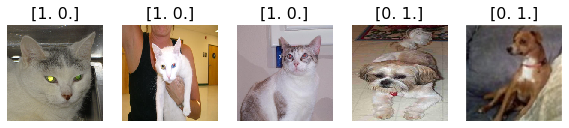

In [5]:
imgs, labels=next(train_batches)
print("X shape:",imgs.shape)
print("Y shape:",labels.shape)
plots(imgs, titles=labels) 

# 2. Making Model 

In [6]:
import keras as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *

In [7]:
imgs.shape[1:]

(224, 224, 3)

In [8]:
def model_creater():
    model=Sequential([
        Conv2D(32,(3,3), activation='relu', input_shape=(imgs.shape[1:])),
        Flatten(),
        Dense(2,activation='softmax')
    ])
    return model

In [9]:
def model_compile(model):
    
    optimizer=Adam(lr=0.0001)
    loss='categorical_crossentropy'
    metrics=['accuracy']
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model

In [10]:
model=model_creater()
model=model_compile(model)

# 3. Training Model

# 4. Saving Model 

In [11]:
from keras.models import load_model
model=load_model('cat_dog_1_layer_model.h5')

# 5. Predicting From Model 

X shape: (5, 224, 224, 3)
Y shape: (5, 2)
Test Labels: [1 0 1 0 1]


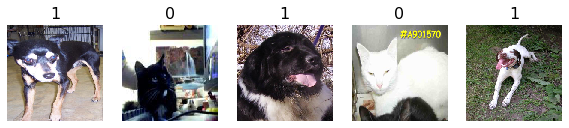

In [12]:
test_imgs, test_labels=next(test_batches)
print("X shape:",test_imgs.shape)
print("Y shape:",test_labels.shape)
test_labels=np.argmax(test_labels, axis=1)
print("Test Labels:", test_labels)
plots(test_imgs, titles=test_labels) 

In [13]:
predictions=model.predict_generator(test_batches,steps=1, verbose=0)
predictions=np.argmax(predictions, axis=1)
predictions

array([1, 1, 1, 1, 1])

In [14]:
from sklearn.metrics import confusion_matrix 

def plot_confusion_matrix(cm,classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    ticks_marks=np.arange(len(classes))
    plt.xticks(ticks_marks, classes, rotation=45)
    plt.yticks(ticks_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [15]:
cm=confusion_matrix(test_labels, predictions)

Confusion matrix, without normalization
[[0 2]
 [0 3]]


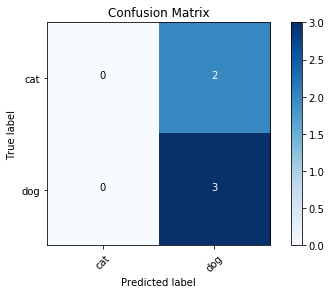

In [16]:
plot_confusion_matrix(cm,classes=["cat","dog"])

# 6. Build Fine Tuned VGG16 Model

In [17]:
import keras
vgg16_model=keras.applications.vgg16.VGG16()
vgg16_model.save('vgg16_model.h5')

In [18]:
vgg16_model=load_model('vgg16_model.h5')

/home/boo/Software/miniconda3/envs/shiv/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [19]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [20]:
type(vgg16_model)

keras.engine.training.Model

In [21]:
model=Sequential()
for layers in vgg16_model.layers[:-1]:
    model.add(layers)

for layer in model.layers:
    layer.trainabe=False
    
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

# 7. Training Model

In [22]:
model=model_compile(model)

model.fit_generator(train_batches, steps_per_epoch=int(train_batches.n/(batch_size)),
                    validation_data=valid_batches, validation_steps=int(valid_batches.n/(batch_size)), 
                    epochs=8, verbose=2)
model.save("vgg13_cat_dog_model.h5")

Epoch 1/8
 - 109s - loss: 0.7521 - accuracy: 0.5963 - val_loss: 0.5713 - val_accuracy: 0.7132
Epoch 2/8
 - 104s - loss: 0.6130 - accuracy: 0.6985 - val_loss: 0.5220 - val_accuracy: 0.6686
Epoch 3/8
 - 104s - loss: 0.4173 - accuracy: 0.8057 - val_loss: 0.2968 - val_accuracy: 0.8712
Epoch 4/8
 - 106s - loss: 0.2973 - accuracy: 0.8862 - val_loss: 0.3756 - val_accuracy: 0.9167
Epoch 5/8
 - 106s - loss: 0.2113 - accuracy: 0.9212 - val_loss: 0.0279 - val_accuracy: 0.8674
Epoch 6/8
 - 106s - loss: 0.2269 - accuracy: 0.9123 - val_loss: 0.2134 - val_accuracy: 0.9015
Epoch 7/8
 - 106s - loss: 0.1272 - accuracy: 0.9489 - val_loss: 1.1528 - val_accuracy: 0.9167
Epoch 8/8
 - 106s - loss: 0.1153 - accuracy: 0.9578 - val_loss: 0.1779 - val_accuracy: 0.9167


# 8. Predicting from Model

X shape: (50, 224, 224, 3)
Y shape: (50, 2)
Test Labels: [0 1 0 0 1 0 0 1 1 1 1 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 1 1 1 0 1
 1 0 1 0 1 0 1 1 0 1 1 0 0]


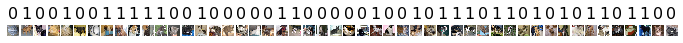

In [36]:
test_imgs, test_labels=next(test_batches)
print("X shape:",test_imgs.shape)
print("Y shape:",test_labels.shape)
test_labels=np.argmax(test_labels, axis=1)
print("Test Labels:", test_labels)
plots(test_imgs, titles=test_labels) 

In [37]:
predictions=model.predict_generator(test_batches,steps=1, verbose=0)
predictions=np.argmax(predictions, axis=1)
predictions

array([0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 0])

In [38]:
cm=confusion_matrix(test_labels, predictions)

Confusion matrix, without normalization
[[21  6]
 [ 4 19]]


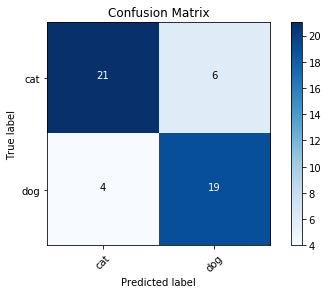

In [39]:
plot_confusion_matrix(cm,classes=["cat","dog"])